# Analysis for once-through scenarios
This notebook provides analysis for all of the once-through fuel cycle scenarios that are included in 
Amanda Bachmann's dissertation. Analysis of each scenario includes the number of reactors deployed, the uranium resources, the SWU capacity, and the amount of waste produced. 

Scenarios are numbers as follows:
* 1: LWRs
* 2: MMR, no growth
* 3: Xe-100, no growth
* 4: Xe-100 and MMR, no growth
* 5: MMR and VOYGR, no growth
* 6: Xe-100 and VOYGR, no growth
* 7: Xe-100, MMR, and VOYGR, no growth
* 8: MMR, 1% growth
* 9: Xe-100, 1% growth
* 10: Xe-100 and MMR, 1% growth
* 11: MMR and VOYGR, 1% growth
* 12: Xe-100 and VOYGR, 1% growth
* 13: Xe-100, MMR, and VOYGR, 1% growth

Analysis of scenario 1 is performed separately, then the no growth scenarios are all analyzed together, followed by the 1% growth scenarios. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

import cymetric as cym
sys.path.insert(0,'../../../scripts')
import transition_metrics as tm
import dataframe_analysis as dfa

In [2]:
# Enrichment Constants
assays = {'LWR': 0.043, 'MMR':0.1975, 'Xe-100':0.155, 
          'VOYGR':0.0409, 'feed':0.00711,'tails':0.002}

# Reactor Deployment Constants
non_lwr = ['Sink_HLW', 'Sink_LLW', 'Mine',
                 'Enrichment', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA',
                 'MMR', 'Xe-100','VOYGR', 'Xe-100CoolingPool',
                 'MMRCoolingPool', 'VOYGRCoolingPool']
adv_rxs = ['MMR', 'Xe-100', 'VOYGR']

#Plotting orders
plotting_order_nogrowth = ['s5','s2','s6','s7','s4','s3']
plotting_order_1percent = ['s11','s08','s12','s13','s10','s09']
colors = {'s2':'tab:orange', 's3':'tab:purple','s4':'tab:brown',
                   's5':'tab:blue', 's6':'tab:red', 's7':'tab:green',
                   's08':'tab:orange', 's09':'tab:purple','s10':'tab:brown',
                   's11':'tab:blue', 's12':'tab:red', 's13':'tab:green'}
lines = {'s2':(0,(3,5,1)), 's3':(0,(5,3)),'s4':'-.','s5':(0,(5,1)), 's6':(0,(5,5)), 's7':(0, (3,1,1,1)),
                's08':(0,(3,5,1)), 's09':(0,(5,3)),'s10':'-.','s11':(0,(5,1)), 's12':(0,(5,5)), 's13':(0, (3,1,1,1))}
labels = {'s2':'Scenario 2', 's3':'Scenario 3', 's4':'Scenario 4', 's5':'Scenario 5',
         's6':'Scenario 6', 's7':'Scenario 7', 's08':'Scenario 8', 's09':'Scenario 9',
         's10':'Scenario 10', 's11':'Scenario 11', 's12':'Scenario 12', 's13':'Scenario 13'}
legend_order = [1, 5, 4, 0, 2, 3]

# Mass fraction of uranium in fuel for each type of reactor
uranium_fractions = {'LWR':1, 'MMR':0.881481, 'Xe-100':0.895285, 'VOYGR':0.881481}

#Waste commodity names for each type of reactor
waste_commodity = {'LWR':'spent_uox', 'MMR':'spent_MMR_haleu',
                   'Xe-100':'spent_xe100_haleu', 'VOYGR':'spent_smr_fuel'}

#Time period
time = np.linspace(2025, 2089, 65)

## Scenario 1

In [201]:
s1_outfile = "../outputs/united_states_2020.sqlite"

In [202]:
# Reactor Deployment
s1_nonlwr = ['Sink_HLW', 'Sink_LLW', 'Mine',
                 'Enrichment', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA']
s1_reactors = tm.get_lwr_totals(s1_outfile, s1_nonlwr)
s1_reactors = dfa.add_year(s1_reactors)

In [203]:
s1_metrics = tm.get_metrics(s1_outfile)
s1_agents = s1_metrics.eval("Agents")
s1_lwrs = s1_agents.loc[s1_agents['Spec'] == ':cycamore:Reactor']

In [204]:
print('Total Number of LWRs deployed:', len(s1_lwrs))
print('Max LWRs deployed:', s1_reactors['lwr_total'].max())
print('LWRS deployed in January 2025:', s1_reactors['lwr_total'][721])
print(s1_reactors[['lwr_total','Year']][1087:1091])
print(s1_reactors[['lwr_total','Year']][30:35])

Total Number of LWRs deployed: 115
Max LWRs deployed: 109.0
LWRS deployed in January 2025: 92.0
Prototype  lwr_total     Year
1087             1.0  2055.58
1088             1.0  2055.67
1089             1.0  2055.75
1090             0.0  2055.83
Prototype  lwr_total     Year
30               0.0  1967.50
31               0.0  1967.58
32               2.0  1967.67
33               2.0  1967.75
34               2.0  1967.83


In [205]:
#energy
s1_energy = tm.get_annual_electricity(s1_outfile)
s1_energy[55:60]

,Year,Energy
55,2022,88.511612
56,2023,88.511612
57,2024,88.423739
58,2025,87.198156
59,2026,86.325454


Annual electricity for 2025:89.45655 GWe-yr


Monthly electricity for 2025:
* January: 91.448
* February: 91.412
* March: 91.376
* April: 89.396
* May: 88.573
* June: 89.3
* July: 91.130
* August: 84.061
* Spetember: 86.184
* October: 91.514
* November:90.791
* December: 83.104

In [206]:
#Compare simulated LWR energy to actual
energy = pd.read_csv("../../../database/MER_T07_02A.csv", usecols=[1,2,3])
energy = energy.loc[(energy['Column_Order'] == 5)].reset_index()
energy = energy.astype('float64')
energy['YYYYMM'] = energy['YYYYMM'].map(str)
actual_energy = []
for index, row in enumerate(energy['YYYYMM']):
    if row[4:] == '13.0':
        actual_energy.append(energy['Value'][index]*1.14155e-4)

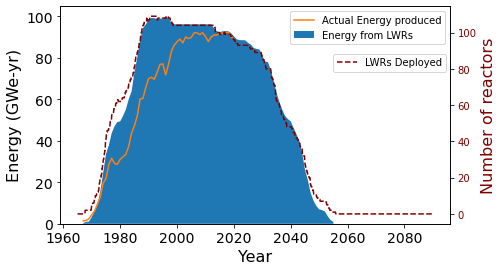

In [207]:
#combine energy and reactors for scenario 1 into a single plot
fig = plt.figure(figsize=(7,4))
ax1 = fig.add_subplot(111)
ax1.stackplot(s1_energy['Year'], s1_energy['Energy'], labels=['Energy from LWRs'])
ax1.plot(s1_energy['Year'][:54], actual_energy[19:], label='Actual Energy produced')
ax1.legend()
ax1.set_ylabel('Energy (GWe-yr)', fontsize=16)

ax2 = ax1.twinx()
ax2.plot(s1_reactors['Year'], s1_reactors['lwr_total'], 'maroon', 
         linestyle='--', label='LWRs Deployed')
ax2.legend(loc=(0.7, 0.7))
ax2.set_ylabel('Number of reactors', color='maroon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='maroon')

ax1.set_xlabel('Year', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax2.tick_params(axis='both', which='minor', labelsize=14)
plt.savefig('figures/s1_energy_reactors.pdf', bbox_inches='tight')

Text(0, 0.5, 'Energy (GWe-yr)')

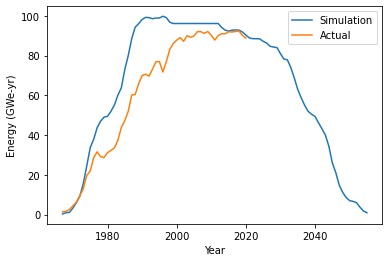

In [208]:
plt.plot(s1_energy['Year'], s1_energy['Energy'], label='Simulation')
plt.plot(s1_energy['Year'][:54], actual_energy[19:], label='Actual')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Energy (GWe-yr)')

In [209]:
s1_transactions = tm.add_receiver_prototype(s1_outfile)

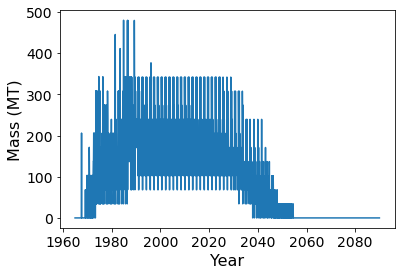

In [210]:
#Uranium resources sent to reactors
s1_uox = dfa.commodity_mass_traded(s1_transactions, 'fresh_uox')
plt.plot(s1_uox['Year'], s1_uox['Quantity']/1000)
plt.ylabel('Mass (MT)', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/s1_uox.pdf', bbox_inches='tight')

In [211]:
print('Max uranium:',s1_uox['Quantity'].max()/1000)
print('Average across entire time:',s1_uox['Quantity'][32:1089].mean()/1000)
print('Average after 2025:',s1_uox['Quantity'][721:1089].mean()/1000)
print('Average before 2025:',s1_uox['Quantity'][32:721].mean()/1000)
print('Total after 2025:', s1_uox['Quantity'][721:].cumsum()[1499]/1000)
print('Total:', s1_uox['Quantity'].cumsum()[1499]/1000)

Max uranium: 479.95435684646645
Average across entire time: 135.64548926932432
Average after 2025: 81.48204943171557
Average before 2025: 164.5745834061023
Total after 2025: 29985.394190871393
Total: 143377.28215767496


1150385.2384471095


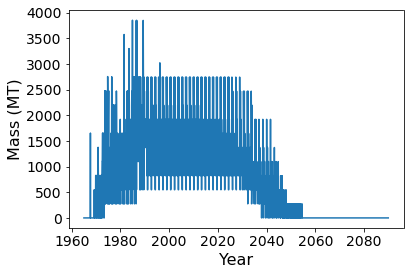

In [213]:
#Natural uranium needed
s1_tails = dfa.calculate_tails(s1_uox['Quantity'], assays['LWR'], assays['tails'], assays['feed'])
s1_feed = dfa.calculate_feed(s1_uox['Quantity'], s1_tails)
print(s1_feed.cumsum()[1499]/1000)

plt.plot(s1_uox['Year'], s1_feed/1000)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Mass (MT)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/s1_feed.pdf', bbox_inches='tight')

In [214]:
print('Maximum needed:',s1_feed.max()/1000)
print('Average feed:',s1_feed[32:1089].mean()/1000)
print('Average feed after 2025:', s1_feed[721:1089].mean()/1000)
print('Average feed before 2025:', s1_feed[32:721].mean()/1000)
print('Total after 2025:', s1_feed[721:].cumsum()[1499]/1000)
print('Total:', s1_feed.cumsum()[1499]/1000)

Maximum needed: 3850.905798572431
Average feed: 1088.3493268184534
Average feed after 2025: 653.7698682388136
Average feed before 2025: 1320.4614324168674
Total after 2025: 240587.31151188293
Total: 1150385.2384471095


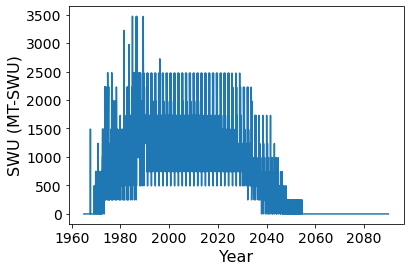

In [215]:
# SWU capacity 
s1_swu = dfa.calculate_SWU(s1_uox['Quantity'], assays['LWR'], s1_tails, 
                          assays['tails'], s1_feed, assays['feed'])
plt.plot(s1_uox["Year"], s1_swu/1000)
plt.xlabel('Year', fontsize=16)
plt.ylabel('SWU (MT-SWU)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/s1_swu.pdf', bbox_inches='tight')

In [216]:
print('Maximum needed:',s1_swu.max()/1000)
print('Average SWU:',s1_swu[32:1089].mean()/1000)
print('Average SWU after 2025:', s1_swu[721:1089].mean()/1000)
print('Average SWU before 2025:', s1_swu[32:721].mean()/1000)

Maximum needed: 3470.057313554395
Average SWU: 980.7133019531188
Average SWU after 2025: 589.1130636082011
Average SWU before 2025: 1189.8698878906073


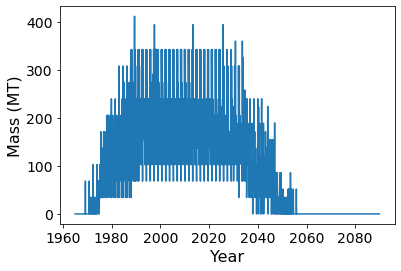

In [218]:
# waste discharged
s1_waste = dfa.commodity_mass_traded(s1_transactions, 'spent_uox')

plt.plot(s1_waste['Year'], s1_waste['Quantity']/1000)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Mass (MT)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/s1_waste.pdf', bbox_inches='tight')

In [219]:
print('Maximum needed:',s1_waste['Quantity'].max())
print('Average waste:',s1_waste['Quantity'][32:1089].mean())
print('Average waste after 2025:', s1_waste['Quantity'][721:1089].mean())
print('Average waste before 2025:', s1_waste['Quantity'][32:721].mean())
print('Cumulative:', s1_waste['Quantity'].cumsum()[1499]/1000)

Maximum needed: 411145.2282157625
Average waste: 130016.69172519061
Average waste after 2025: 94269.9463287027
Average waste before 2025: 149109.2930400057
Cumulative: 137479.3568464718


## No growth scenarios

In [3]:
out_files_nogrowth = {'s2_outfile':"../outputs/mmr_nogrowth.sqlite",
            's3_outfile':"../outputs/xe100_nogrowth.sqlite",
            's4_outfile':"../outputs/xe100_mmr_nogrowth.sqlite",
            's5_outfile':"../outputs/mmr_voygr_nogrowth.sqlite",
            's6_outfile':"../outputs/xe100_voygr_nogrowth.sqlite",
            's7_outfile':"../outputs/xe100_mmr_voygr_nogrowth.sqlite"}

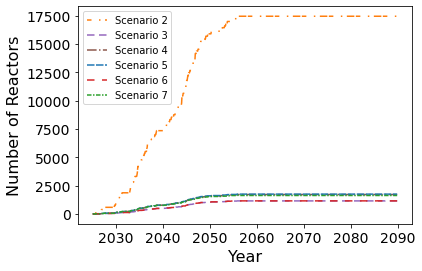

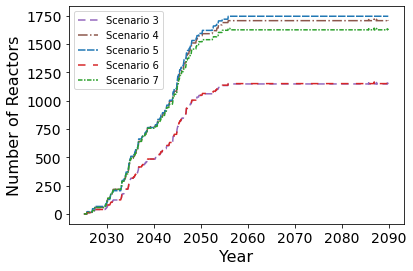

In [221]:
reactors_nogrowth = {'s2_reactors':'',
            's3_reactors':"",
            's4_reactors':"",
            's5_reactors':"",
            's6_reactors':"",
            's7_reactors':""}
plt.figure(0)
for key in reactors_nogrowth:
    scenario = key[:2]
    reactors_nogrowth[key] = tm.get_prototype_totals(out_files_nogrowth[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_nogrowth[key]['Year'][721:], reactors_nogrowth[key]['advrx_total'][721:], 
             label=labels[scenario],
            color = colors[scenario], linestyle=lines[scenario])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_reactors.pdf', bbox_inches='tight')

plt.figure(1)
for key in ['s3_reactors','s4_reactors', 's5_reactors','s6_reactors','s7_reactors']:
    scenario = key[:2]
    reactors_nogrowth[key] = tm.get_prototype_totals(out_files_nogrowth[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_nogrowth[key]['Year'][721:], reactors_nogrowth[key]['advrx_total'][721:], 
            label=labels[scenario],
            color=colors[scenario], linestyle=lines[scenario])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_reactors_3-7.pdf', bbox_inches='tight')

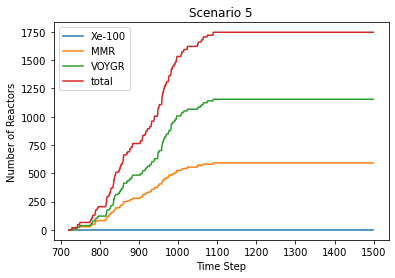

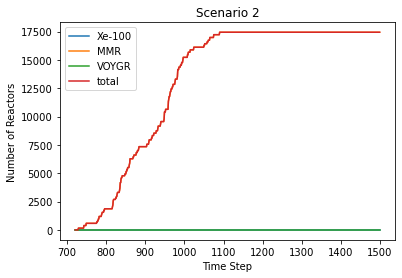

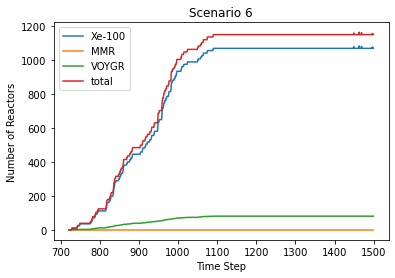

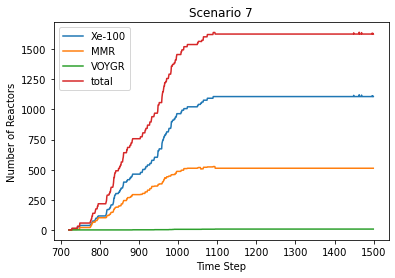

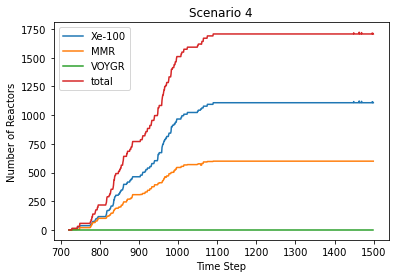

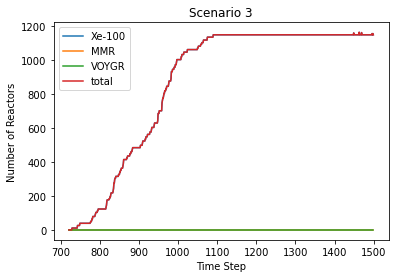

In [222]:
for scenario in plotting_order_nogrowth:
        plt.figure()
        for reactor in ['Xe-100', 'MMR', 'VOYGR']:
            num_rxs = reactors_nogrowth[scenario+'_reactors'][reactor+'_total']
            plt.plot(num_rxs[721:], label = reactor)
        plt.plot(reactors_nogrowth[scenario+'_reactors']['advrx_total'][721:], label='total')
        plt.legend()
        plt.title(labels[scenario])
        plt.xlabel('Time Step')
        plt.ylabel('Number of Reactors')

In [223]:
for key in reactors_nogrowth:
    scenario = key[1]
    for adv_rx in adv_rxs:
        print(f'Max {adv_rx} in S{scenario}:', reactors_nogrowth[key][adv_rx +'_total'].max())
        print(f'Max {adv_rx} added in one step in S{scenario}:', reactors_nogrowth[key][adv_rx +'_enter'].max())
        prototype_sum = reactors_nogrowth[key][adv_rx +'_enter'].cumsum()
        print(f'Total number of {adv_rx} deployed in S{scenario}:', prototype_sum.iloc[-1])
    print(f'Max Adv Rx in S{scenario}:', reactors_nogrowth[key]['advrx_total'].max())
    print(f'Max Adv Rx added in one step in S{scenario}:', reactors_nogrowth[key]['advrx_enter'].max())
    advrx_sum = reactors_nogrowth[key]['advrx_enter'].cumsum()
    print(f'Total number of reactors deployed in S{scenario}:', advrx_sum.iloc[-1])  

Max MMR in S2: 17440.0
Max MMR added in one step in S2: 856.0
Total number of MMR deployed in S2: 51568.0
Max Xe-100 in S2: 0.0
Max Xe-100 added in one step in S2: 0.0
Total number of Xe-100 deployed in S2: 0.0
Max VOYGR in S2: 0.0
Max VOYGR added in one step in S2: 0.0
Total number of VOYGR deployed in S2: 0.0
Max Adv Rx in S2: 17440.0
Max Adv Rx added in one step in S2: 856.0
Total number of reactors deployed in S2: 51568.0
Max MMR in S3: 0.0
Max MMR added in one step in S3: 0.0
Total number of MMR deployed in S3: 0.0
Max Xe-100 in S3: 1163.0
Max Xe-100 added in one step in S3: 46.0
Total number of Xe-100 deployed in S3: 1201.0
Max VOYGR in S3: 0.0
Max VOYGR added in one step in S3: 0.0
Total number of VOYGR deployed in S3: 0.0
Max Adv Rx in S3: 1163.0
Max Adv Rx added in one step in S3: 46.0
Total number of reactors deployed in S3: 1201.0
Max MMR in S4: 599.0
Max MMR added in one step in S4: 16.0
Total number of MMR deployed in S4: 1804.0
Max Xe-100 in S4: 1123.0
Max Xe-100 added in

In [224]:
for key in reactors_nogrowth:
    print(reactors_nogrowth[key]['advrx_total'].ne(0).idxmax())

729
729
729
729
729
729


In [225]:
reactors_nogrowth['s2_reactors'][['MMR_enter', 'MMR_exit', 'MMR_total']]

Prototype,MMR_enter,MMR_exit,MMR_total
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
1495,210.0,-210.0,17440.0
1496,114.0,-114.0,17440.0
1497,0.0,0.0,17440.0
1498,104.0,-104.0,17440.0


In [226]:
# Energy
energy_nogrowth = {'s2_energy':'', 's3_energy':'', 's4_energy':'',
          's5_energy':'', 's6_energy':'', 's7_energy':''}
for key in energy_nogrowth:
    scenario = key[:2]
    energy_nogrowth[key] = tm.get_annual_electricity(out_files_nogrowth[scenario + '_outfile'])

(87.0, 88.0)

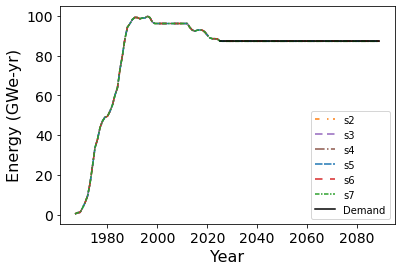

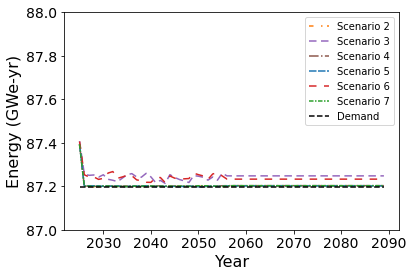

In [228]:
for key in energy_nogrowth:
    scenario = key[:2]
    
    plt.figure(0)
    plt.plot(energy_nogrowth[key]['Year'], energy_nogrowth[key]['Energy'], label=scenario,
            color=colors[scenario], linestyle=lines[scenario])
    
    plt.figure(1)
    plt.plot(energy_nogrowth[key]['Year'][58:], energy_nogrowth[key]['Energy'][58:], label=labels[scenario],
            color=colors[scenario], linestyle=lines[scenario])
plt.figure(0)
plt.plot(np.linspace(2025,2089,65), np.repeat(87.198156, 65), 'k', label='Demand')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Energy (GWe-yr)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_energy.pdf', bbox_inches='tight')

plt.figure(1)
plt.plot(np.linspace(2025,2089,65), np.repeat(87.198156, 65), 'k--', label='Demand')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Energy (GWe-yr)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.ylim([87, 88])
#plt.savefig('figures/nogrowth_energy_after_2025.pdf', bbox_inches='tight')

s2_energy : -0.19500029999997537 -1.299999998138901e-05
s3_energy : -0.20900029999997116 -0.015390900000056718
s4_energy : -0.19500029999997537 -0.00042326666677183766
s5_energy : -0.19500029999997537 -0.0004232666667007834
s6_energy : -0.2082502999999747 -0.019140900000067518
s7_energy : -0.19500029999997537 -0.0007540499999549866


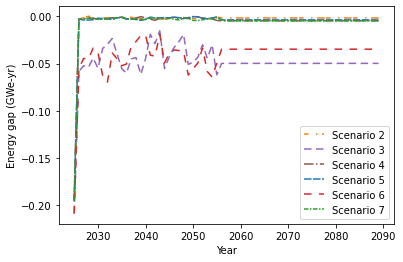

In [230]:
demand = np.repeat(87.198156,65)

for key in energy_nogrowth:
    scenario = key[:2]
    gap = demand-energy_nogrowth[key]['Energy'][58:]
    plt.plot(energy_nogrowth[key]['Year'][58:],gap, color = colors[scenario], linestyle = lines[scenario],
            label=labels[scenario])
    print(key, ':', gap.min(), gap.max())
plt.xlabel('Year')
plt.ylabel('Energy gap (GWe-yr)')
plt.legend()
plt.savefig('figures/nogrowth_energy_gap.pdf')

In [232]:
nogrowth_prototype_energy = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'',
                            's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'',
                            's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'',
                            's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'',
                            's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'', 
                            's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':''}

for scenario in ['s2','s3','s4','s5','s6','s7']:
    for reactor in ['MMR', 'Xe-100','VOYGR']:
        nogrowth_prototype_energy[scenario + '_' + reactor] = tm.get_prototype_energy(
                                                              out_files_nogrowth[scenario +'_outfile'], reactor)
    nogrowth_prototype_energy[scenario + '_LWR'] = tm.get_lwr_energy(out_files_nogrowth[scenario +'_outfile'], 
                                                                     ['MMR', 'Xe-100','VOYGR'])

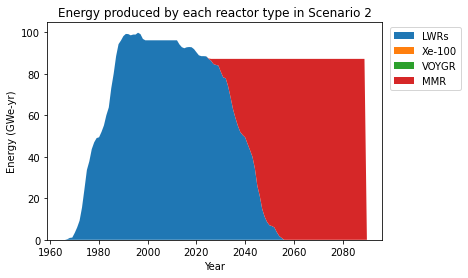

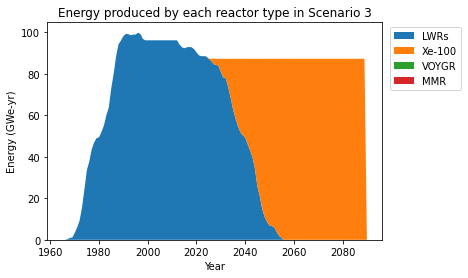

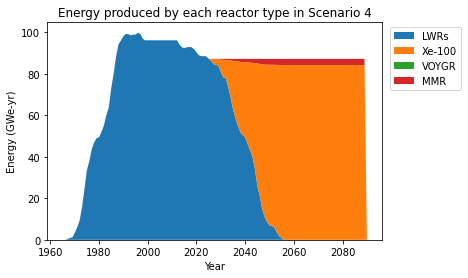

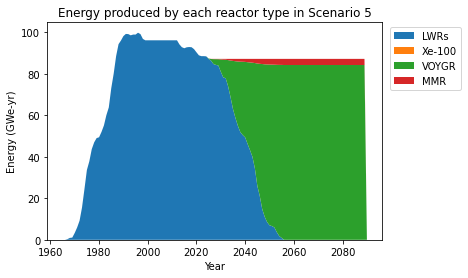

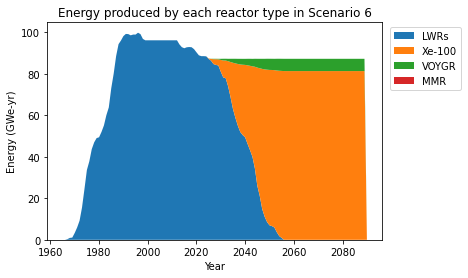

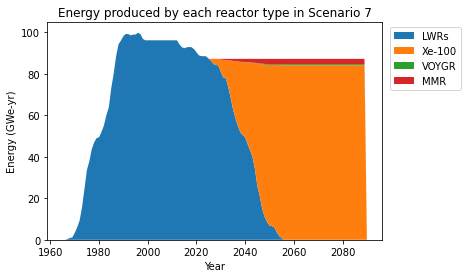

In [233]:
for scenario in ['s2','s3','s4','s5','s6','s7']:
    plt.figure()
    plt.stackplot(nogrowth_prototype_energy[scenario+'_LWR']['Year'], nogrowth_prototype_energy[scenario+'_LWR']['Energy'],
                 nogrowth_prototype_energy[scenario+'_Xe-100']['Energy'],nogrowth_prototype_energy[scenario+'_VOYGR']['Energy'],
                 nogrowth_prototype_energy[scenario+'_MMR']['Energy'], labels = ['LWRs','Xe-100','VOYGR','MMR'])
    plt.xlabel('Year')
    plt.ylabel('Energy (GWe-yr)')
    plt.title(f'Energy produced by each reactor type in {labels[scenario]}')
    plt.legend(bbox_to_anchor=(1.25, 1))
    plt.savefig(f'figures/prototype_energy_{scenario}.png', bbox_inches='tight')

In [4]:
# Fuel mass
transactions_nogrowth = {'s2':'', 's3':'', 's4':'','s5':'', 's6':'','s7':''}
total_fuel_nogrowth = {'s2':'', 's3':'', 's4':'',
             's5':'', 's6':'', 's7':''}
for key in total_fuel_nogrowth:
    scenario = key[:2]
    transactions_nogrowth[scenario] = tm.add_receiver_prototype(out_files_nogrowth[scenario + '_outfile'])
    fuel = dfa.commodity_mass_traded(transactions_nogrowth[scenario], 'fresh_uox')
    total_fuel_nogrowth[key] = dfa.add_year(fuel)

In [5]:
#Dividing fuel mass by prototype
uranium_to_reactors_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'', 's2_total':'',
                       's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'', 's3_total':'',
                       's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'', 's4_total':'',
                       's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'', 's5_total':'',
                       's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'', 's6_total':'',
                       's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':'', 's7_total':'',}
for key in uranium_to_reactors_nogrowth:
    scenario = key[:2]
    reactor = key[3:]
    if reactor == 'LWR':
        uranium_to_reactors_nogrowth[key] = dfa.commodity_to_LWR(transactions_nogrowth[scenario], 
                                                        'fresh_uox', adv_rxs)
    elif reactor != 'total': 
        uranium_to_reactors_nogrowth[key] = dfa.commodity_to_prototype(transactions_nogrowth[scenario], 
                                                        'fresh_uox', reactor)
        uranium_to_reactors_nogrowth[key]['Quantity'] = uranium_to_reactors_nogrowth[key]['Quantity']*uranium_fractions[reactor]

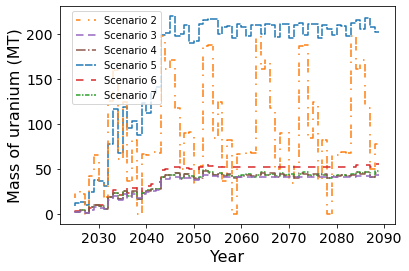

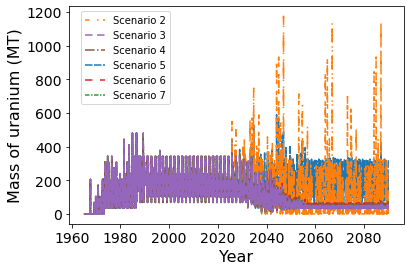

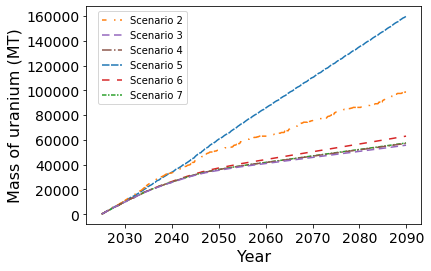

In [6]:
for key in plotting_order_nogrowth:
    ax1 = plt.figure(1)
    AR_uranium = uranium_to_reactors_nogrowth[key + '_MMR'].copy()
    for reactor in ['Xe-100', 'VOYGR']:
        AR_uranium['Quantity'] += uranium_to_reactors_nogrowth[key+'_'+reactor]['Quantity']     
    counter = 721
    averages = []
    for ii in range(0,65):
        year_data = AR_uranium['Quantity'][counter:counter+12]/1000
        averages.append(year_data.mean())
        counter += 12
    
    plt.figure(1)
    plt.step(np.linspace(2025, 2089, 65), averages, label=labels[key],
            color=colors[key], linestyle=lines[key]) 
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax2 = plt.figure(2)
    uranium_to_reactors_nogrowth[key + '_total'] = AR_uranium['Quantity'] 
    uranium_to_reactors_nogrowth[key + '_total'] += uranium_to_reactors_nogrowth[key+'_LWR']['Quantity']
    plt.plot(AR_uranium['Year'], uranium_to_reactors_nogrowth[key+'_total']/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax3 = plt.figure(3)
    plt.plot(uranium_to_reactors_nogrowth[key+'_MMR']['Year'][721:], 
            uranium_to_reactors_nogrowth[key+'_total'][721:].cumsum()/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/nogrowth_AR_uranium.pdf', bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax2.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax2.savefig('figures/nogrowth_uranium.pdf', bbox_inches='tight')
handles, legend_labels = ax3.gca().get_legend_handles_labels()
ax3.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax3.savefig('figures/nogrowth_uranium_cumulative.pdf', bbox_inches='tight')

In [7]:
#Reporting uranium masses
for scenario in ['s2','s3','s4','s5','s6','s7']:
    HALEU_mass = uranium_to_reactors_nogrowth[scenario+'_MMR'] + uranium_to_reactors_nogrowth[scenario+'_Xe-100']
    print('Average HALEU mass in', scenario,'after 2025:', HALEU_mass[721:]['Quantity'].mean()/1000)
    AR_mass = HALEU_mass + uranium_to_reactors_nogrowth[scenario+'_VOYGR']
    print('Non-HALEU max in:',scenario, uranium_to_reactors_nogrowth[scenario+'_VOYGR'][721:]['Quantity'].max()/1000)
    print('Average mass in', scenario, 'after 2025:', 
          AR_mass[721:]['Quantity'].mean()/1000)
    print('Maximum mass in', scenario, 'after 2025:', 
          AR_mass[721:]['Quantity'].max()/1000)
    print('Cumulative mass in', scenario, 'after 2025:',AR_mass[721:]['Quantity'].cumsum()[1499]/1000)

Average HALEU mass in s2 after 2025: 88.15739283295943
Non-HALEU max in: s2 0.0
Average mass in s2 after 2025: 88.15739283295943
Maximum mass in s2 after 2025: 1139.9601558804986
Cumulative mass in s2 after 2025: 68674.60901687539
Average HALEU mass in s3 after 2025: 32.99048780992576
Non-HALEU max in: s3 0.0
Average mass in s3 after 2025: 32.99048780992576
Maximum mass in s3 after 2025: 90.42888812450052
Cumulative mass in s3 after 2025: 25699.59000393211
Average HALEU mass in s4 after 2025: 34.89165288760236
Non-HALEU max in: s4 0.0
Average mass in s4 after 2025: 34.89165288760236
Maximum mass in s4 after 2025: 98.43502841197635
Cumulative mass in s4 after 2025: 27180.597599442357
Average HALEU mass in s5 after 2025: 3.0224610325913837
Non-HALEU max in: s5 549.4698238692458
Average mass in s5 after 2025: 166.66430844936824
Maximum mass in s5 after 2025: 568.1140320261699
Cumulative mass in s5 after 2025: 129831.49628205824
Average HALEU mass in s6 after 2025: 30.716685605017563
Non-H

In [10]:
#SWU Calculations
tails_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'',
        's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'',
        's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'',
        's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'',
        's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'',
        's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':''}
feed_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'', 's2_total':'',
        's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'', 's3_total':'',
        's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'', 's4_total':'',
        's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'', 's5_total':'',
        's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'', 's6_total':'',
        's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':'', 's7_total':'',}
SWU_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'', 's2_total':'',
        's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'', 's3_total':'',
        's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'', 's4_total':'',
        's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'', 's5_total':'',
        's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'', 's6_total':'',
        's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':'', 's7_total':'',}
for key in feed_nogrowth:
    reactor = key[3:]
    if reactor != 'total':
        tails_nogrowth[key] = dfa.calculate_tails(uranium_to_reactors_nogrowth[key]['Quantity'], 
                                    assays[reactor], assays['tails'], assays['feed'])
        feed_nogrowth[key] = dfa.calculate_feed(uranium_to_reactors_nogrowth[key]['Quantity'], 
                                           tails_nogrowth[key])
        SWU_nogrowth[key] = dfa.calculate_SWU(uranium_to_reactors_nogrowth[key]['Quantity'],
                                assays[reactor], tails_nogrowth[key], assays['tails'],
                                feed_nogrowth[key], assays['feed'])

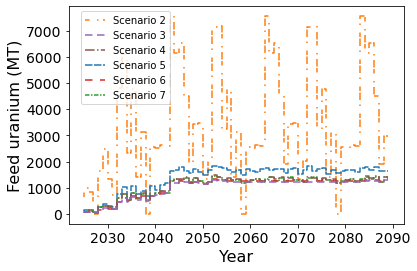

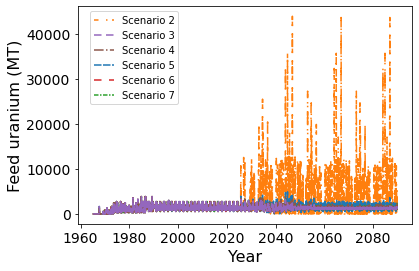

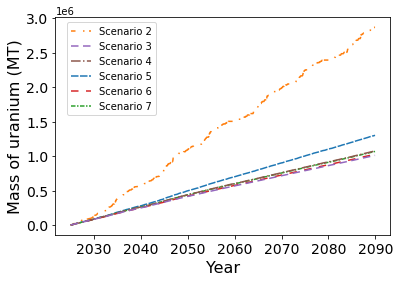

In [11]:
for key in ['s2','s5','s7','s6','s4','s3']:
    AR_feed = feed_nogrowth[key+'_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_feed += feed_nogrowth[key + '_' + reactor]
    counter = 721
    averages = []
    for ii in range(0,65):
        year_data = AR_feed[counter:counter+12]/1000
        averages.append(year_data.mean())
        counter += 12
    ax0 = plt.figure(0)
    plt.step(np.linspace(2025, 2089, 65), averages, label=labels[key],
            color=colors[key], linestyle=lines[key]) 
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax1 = plt.figure(1)
    feed_nogrowth[key+'_total'] = AR_feed + feed_nogrowth[key +'_LWR']
    plt.plot(uranium_to_reactors_nogrowth[key + '_MMR']['Year'], feed_nogrowth[key+'_total']/1000, 
             label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax2 = plt.figure(2)
    plt.plot(uranium_to_reactors_nogrowth[key+'_MMR']['Year'][721:], feed_nogrowth[key+'_total'][721:].cumsum()/1000, 
             label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
order = [0, 5, 4, 1, 3, 2]
handles, legend_labels = ax0.gca().get_legend_handles_labels()
ax0.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax0.savefig('figures/nogrowth_AR_feed.pdf', bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/nogrowth_feed.pdf', bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax2.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax2.savefig('figures/nogrowth_feed_cumulative.pdf', bbox_inches='tight')

In [12]:
#Reporting feed masses
for scenario in ['s2','s3','s4','s5','s6','s7']:
    HALEU_feed = feed_nogrowth[scenario+'_MMR'] + feed_nogrowth[scenario+'_Xe-100']
    print('Average feed for HALEU in',scenario, 'after 2025:', HALEU_feed[721:].mean()/1000)
    AR_feed = HALEU_feed + feed_nogrowth[scenario+'_VOYGR']
    print('AR Average mass in', scenario, 'after 2025:', AR_feed[721:].mean()/1000)
    print('AR Maximum mass in', scenario, 'after 2025:', AR_feed[721:].max()/1000)
    print('AR Cumulative mass in', scenario, 'after 2025:', AR_feed[721:].cumsum()[1499]/1000)

Average feed for HALEU in s2 after 2025: 3372.7534831396415
AR Average mass in s2 after 2025: 3372.7534831396415
AR Maximum mass in s2 after 2025: 43612.95704004647
AR Cumulative mass in s2 after 2025: 2627374.9633657844
Average feed for HALEU in s3 after 2025: 987.7778150525717
AR Average mass in s3 after 2025: 987.7778150525717
AR Maximum mass in s3 after 2025: 2707.5577070545164
AR Cumulative mass in s3 after 2025: 769478.9179259533
Average feed for HALEU in s4 after 2025: 1070.35089568816
AR Average mass in s4 after 2025: 1070.35089568816
AR Maximum mass in s4 after 2025: 3069.108165666974
AR Cumulative mass in s4 after 2025: 833803.3477410763
Average feed for HALEU in s5 after 2025: 115.63427238192088
AR Average mass in s5 after 2025: 1361.3618388227464
AR Maximum mass in s5 after 2025: 4896.148501603191
AR Cumulative mass in s5 after 2025: 1060500.872442923
Average feed for HALEU in s6 after 2025: 919.6972402285099
AR Average mass in s6 after 2025: 1008.5592730767911
AR Maximum m

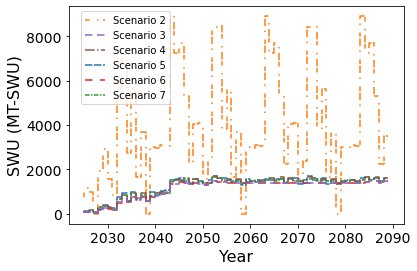

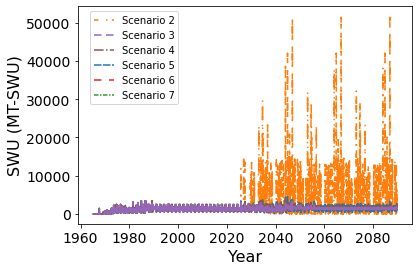

In [13]:
for key in ['s2', 's5', 's7', 's6', 's4', 's3']:
    AR_SWU = SWU_nogrowth[key+'_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_SWU += SWU_nogrowth[key + '_' + reactor]
    counter = 721
    averages = []
    for ii in range(0,65):
        year_data = AR_SWU[counter:counter+12]/1000
        averages.append(year_data.mean())
        counter += 12
    ax0 = plt.figure(0)
    plt.step(np.linspace(2025, 2089, 65), averages, label=labels[key],
            color=colors[key], linestyle=lines[key]) 
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (MT-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax1 = plt.figure(1)
    SWU_nogrowth[key+'_total'] = AR_SWU + SWU_nogrowth[key +'_LWR']
    plt.plot(uranium_to_reactors_nogrowth[key + '_MMR']['Year'], SWU_nogrowth[key+'_total']/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (MT-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
handles, legend_labels = ax0.gca().get_legend_handles_labels()
ax0.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax0.savefig('figures/nogrowth_AR_SWU.pdf', bbox_inches='tight')
handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/nogrowth_SWU.pdf', bbox_inches='tight')

In [14]:
#Reporting SWU Requirements
for scenario in ['s2','s3','s4','s5','s6','s7']:
    HALEU_SWU = SWU_nogrowth[scenario+'_MMR'] + SWU_nogrowth[scenario+'_Xe-100']
    print('Average HALEU SWU in', scenario, 'after 2025:', HALEU_SWU[721:].mean()/1000)
    AR_SWU = HALEU_SWU + SWU_nogrowth[scenario+'_VOYGR']
    print('Average SWU in ', scenario, ':', AR_SWU[721:].mean()/1000)
    print('Maximum SWU in ', scenario, ':', AR_SWU[721:].max()/1000)

Average HALEU SWU in s2 after 2025: 3977.5103106075985
Average SWU in  s2 : 3977.5103106075985
Maximum SWU in  s2 : 51433.046372956334
Average HALEU SWU in s3 after 2025: 1137.220480609721
Average SWU in  s3 : 1137.220480609721
Maximum SWU in  s3 : 3117.1889365942234
Average HALEU SWU in s4 after 2025: 1235.5916203620636
Average SWU in  s4 : 1235.5916203620636
Maximum SWU in  s4 : 3549.13980374275
Average HALEU SWU in s5 after 2025: 136.36825607264666
Average SWU in  s5 : 1240.7853113716283
Maximum SWU in  s5 : 4549.5605719365685
Average HALEU SWU in s6 after 2025: 1058.8398743217724
Average SWU in  s6 : 1137.621742275918
Maximum SWU in  s6 : 3124.582351879367
Average HALEU SWU in s7 after 2025: 1216.9019040391568
Average SWU in  s7 : 1222.8171294864558
Maximum SWU in  s7 : 3549.13980374275


In [16]:
# Waste discharged from reactors
waste_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'', 's2_total':'',
                    's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'', 's3_total':'',
                    's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'', 's4_total':'',
                    's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'', 's5_total':'',
                    's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'', 's6_total':'',
                    's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':'', 's7_total':''}
for key in waste_nogrowth:
    scenario = key[:2]
    reactor = key[3:]
    if reactor != 'total':
        waste_nogrowth[key] = dfa.commodity_mass_traded(transactions_nogrowth[scenario], waste_commodity[reactor])

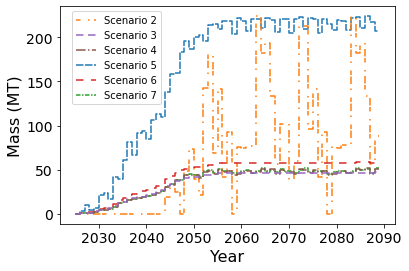

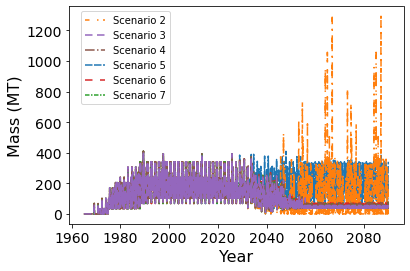

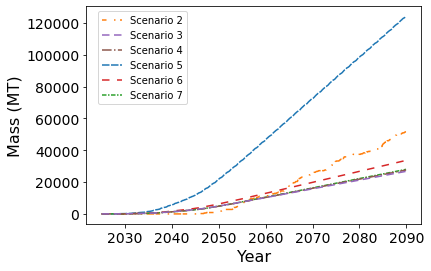

In [17]:
for key in plotting_order_nogrowth:
    AR_waste = waste_nogrowth[key + '_MMR'].copy()
    for reactor in ['Xe-100', 'VOYGR']:
        AR_waste['Quantity'] += waste_nogrowth[key + '_' + reactor]['Quantity']
    counter = 721
    averages = []
    for ii in range(0,65):
        year_data = AR_waste['Quantity'][counter:counter+12]/1000
        averages.append(year_data.mean())
        counter += 12
    ax0 = plt.figure(0)
    plt.step(np.linspace(2025, 2089, 65), averages, label=labels[key],
            color=colors[key], linestyle=lines[key]) 
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax1 = plt.figure(1)
    waste_nogrowth[key+'_total'] = AR_waste['Quantity'] + waste_nogrowth[key + '_LWR']['Quantity']
    plt.plot(AR_waste['Year'], waste_nogrowth[key+'_total']/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax2 = plt.figure(2)
    plt.plot(AR_waste['Year'][721:], AR_waste['Quantity'][721:].cumsum()/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
handles, legend_labels = ax0.gca().get_legend_handles_labels()
ax0.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax0.savefig('figures/nogrowth_AR_waste.pdf', bbox_inches='tight')
handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/nogrowth_waste.pdf', bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax2.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax2.savefig('figures/nogrowth_waste_cumulative.pdf', bbox_inches='tight')

In [18]:
#Reporting waste masses
for scenario in ['s2','s3','s4','s5','s6','s7']:
    HALEU_waste = waste_nogrowth[scenario+'_MMR']['Quantity'] + waste_nogrowth[scenario+'_Xe-100']['Quantity']
    print('Average HALEU waste in', scenario, ': ', HALEU_waste[721:].mean()/1000)
    AR_waste = HALEU_waste + waste_nogrowth[scenario+'_VOYGR']['Quantity']
    print('Average AR waste in', scenario, 'after 2025:', AR_waste[721:].mean()/1000)
    print('Maximum  in', scenario, ':', AR_waste[721:].max()/1000)
    print('Cumulative  in', scenario, ':', AR_waste[721:].cumsum()[1499]/1000)

Average HALEU waste in s2 :  66.18755405391519
Average AR waste in s2 after 2025: 66.18755405391519
Maximum  in s2 : 1293.2328160000031
Cumulative  in s2 : 51560.10460799995
Average HALEU waste in s3 :  34.33120872913981
Average AR waste in s3 after 2025: 34.33120872913981
Maximum  in s3 : 61.51294999999974
Cumulative  in s3 : 26744.011600000154
Average HALEU waste in s4 :  35.43578418485227
Average AR waste in s4 after 2025: 35.43578418485227
Maximum  in s4 : 77.80226799999977
Cumulative  in s4 : 27604.475879999914
Average HALEU waste in s5 :  2.2807244364569965
Average AR waste in s5 after 2025: 159.40429013607292
Maximum  in s5 : 383.6326140000028
Cumulative  in s5 : 124175.9420160009
Average HALEU waste in s6 :  31.96382522464688
Average AR waste in s6 after 2025: 43.18101646983302
Maximum  in s6 : 77.80715999999975
Cumulative  in s6 : 33638.01182999995
Average HALEU waste in s7 :  35.13039530937089
Average AR waste in s7 after 2025: 35.963528659820184
Maximum  in s7 : 81.113547999

## 1% Growth Scenarios

In [142]:
out_files_1percent = {'s08_outfile':"../outputs/mmr_1percent.sqlite",
                    's09_outfile':"../outputs/xe100_1percent.sqlite",
            's10_outfile':"../outputs/xe100_mmr_1percent.sqlite",
            's11_outfile':"../outputs/mmr_voygr_1percent.sqlite",
            's12_outfile':"../outputs/xe100_voygr_1percent.sqlite",
            's13_outfile':"../outputs/xe100_mmr_voygr_1percent.sqlite"}

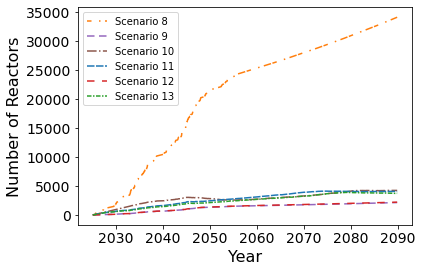

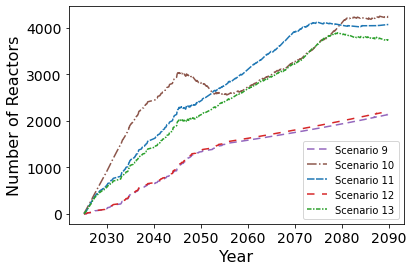

In [146]:
reactors_1percent = {'s08_reactors':"",'s09_reactors':"",
                    's10_reactors':"",'s11_reactors':"",
                    's12_reactors':"",'s13_reactors':""}
plt.figure(0)
for key in reactors_1percent:
    scenario = key[:3]
    reactors_1percent[key] = tm.get_prototype_totals(out_files_1percent[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_1percent[key]['Year'][721:], reactors_1percent[key]['advrx_total'][721:], 
             label=labels[scenario], color=colors[scenario], linestyle=lines[scenario])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/1percent_reactors.pdf', bbox_inches='tight')

plt.figure(1)
for key in ['s09_reactors','s10_reactors','s11_reactors','s12_reactors','s13_reactors']:
    scenario = key[:3]
    reactors_1percent[key] = tm.get_prototype_totals(out_files_1percent[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_1percent[key]['Year'][721:], reactors_1percent[key]['advrx_total'][721:], 
             label=labels[scenario], color=colors[scenario], linestyle=lines[scenario])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/1percent_reactors_9-13.pdf', bbox_inches='tight')

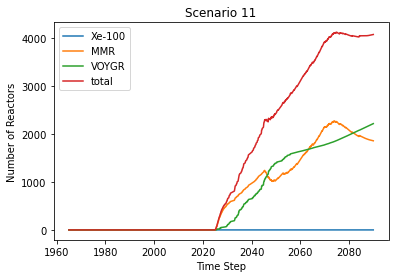

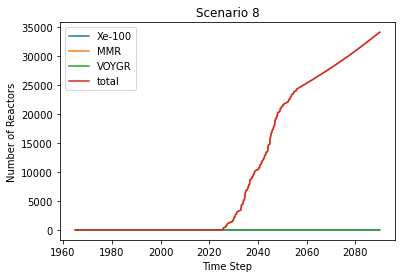

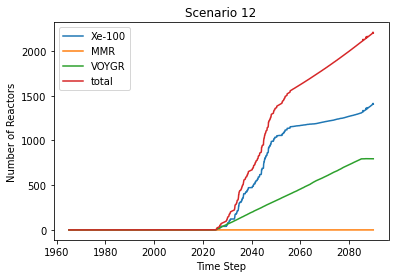

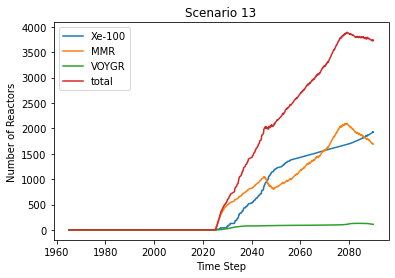

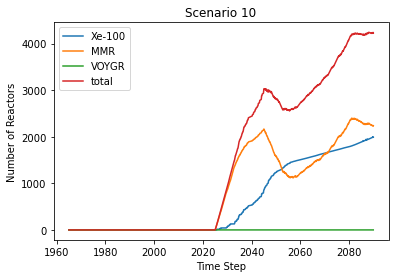

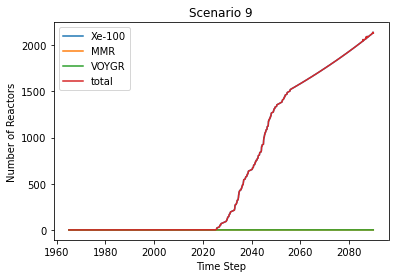

In [147]:
for scenario in plotting_order_1percent:
        plt.figure()
        for reactor in ['Xe-100', 'MMR', 'VOYGR']:
            num_rxs = reactors_1percent[scenario+'_reactors'][reactor+'_total']
            plt.plot(reactors_1percent[scenario+'_reactors']['Year'], num_rxs, label = reactor)
        plt.plot(reactors_1percent[scenario+'_reactors']['Year'], 
                 reactors_1percent[scenario+'_reactors']['advrx_total'], label='total')
        plt.legend()
        plt.title(labels[scenario])
        plt.xlabel('Time Step')
        plt.ylabel('Number of Reactors')

In [88]:
for key in reactors_1percent:
    scenario = key[1:3]
    for adv_rx in adv_rxs:
        print(f'Max {adv_rx} in S{scenario}:', reactors_1percent[key][adv_rx +'_total'].max())
        print(f'Max {adv_rx} added in one step in S{scenario}:', reactors_1percent[key][adv_rx +'_enter'].max())
        prototype_sum = reactors_1percent[key][adv_rx +'_enter'].cumsum()
        print(f'Total number of {adv_rx} deployed in S{scenario}:', prototype_sum.iloc[-1])
    print(f'Max Adv Rx in S{scenario}:', reactors_1percent[key]['advrx_total'].max())
    print(f'Max Adv Rx added in one step in S{scenario}:', reactors_1percent[key]['advrx_enter'].max())
    advrx_sum = reactors_1percent[key]['advrx_enter'].cumsum()
    print(f'Total number of reactors deployed in S{scenario}:', advrx_sum.iloc[-1])  

Max MMR in S08: 34126.0
Max MMR added in one step in S08: 823.0
Total number of MMR deployed in S08: 84142.0
Max Xe-100 in S08: 0.0
Max Xe-100 added in one step in S08: 0.0
Total number of Xe-100 deployed in S08: 0.0
Max VOYGR in S08: 0.0
Max VOYGR added in one step in S08: 0.0
Total number of VOYGR deployed in S08: 0.0
Max Adv Rx in S08: 34126.0
Max Adv Rx added in one step in S08: 823.0
Total number of reactors deployed in S08: 84142.0
Max MMR in S09: 0.0
Max MMR added in one step in S09: 0.0
Total number of MMR deployed in S09: 0.0
Max Xe-100 in S09: 2139.0
Max Xe-100 added in one step in S09: 49.0
Total number of Xe-100 deployed in S09: 2184.0
Max VOYGR in S09: 0.0
Max VOYGR added in one step in S09: 0.0
Total number of VOYGR deployed in S09: 0.0
Max Adv Rx in S09: 2139.0
Max Adv Rx added in one step in S09: 49.0
Total number of reactors deployed in S09: 2184.0
Max MMR in S10: 2494.0
Max MMR added in one step in S10: 16.0
Total number of MMR deployed in S10: 5838.0
Max Xe-100 in S1

In [4]:
# Energy
energy_1percent = {'s08_energy':'', 's09_energy':'', 's10_energy':'',
                  's11_energy':'', 's12_energy':'', 's13_energy':''}

In [7]:
for key in ['s12','s13']:
    energy_1percent[key + '_energy'] = tm.get_annual_electricity(out_files_1percent[key + '_outfile'])

s08_energy : -1.1573601476767266 0.36063174177688495
s09_energy : -1.221110147677308 0.33271507511022946
s10_energy : -1.1573601476774513 0.360631741776956
s11_energy : -1.4069169455757446 0.3426317417774527
s12_energy : -1.252610147676961 0.28421507511049526
s13_energy : -1.169276814343732 0.3135484084436797


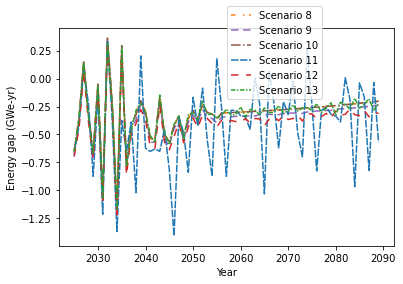

In [8]:
demand = 89.45655* np.exp(0.01*(time-2025))

for key in energy_1percent:
    scenario = key[:3]
    gap = demand-energy_1percent[key]['Energy'][58:]
    plt.figure(1)
    plt.plot(energy_1percent[key]['Year'][58:],gap, color = colors[scenario], linestyle = lines[scenario], 
            label=labels[scenario])
    print(key, ':', gap.min(), gap.max())
plt.xlabel('Year')
plt.ylabel('Energy gap (GWe-yr)')
plt.legend(bbox_to_anchor=(0.8, 0.65))
plt.savefig('figures/1percent_energy_gap.pdf')

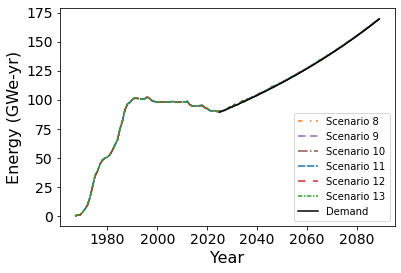

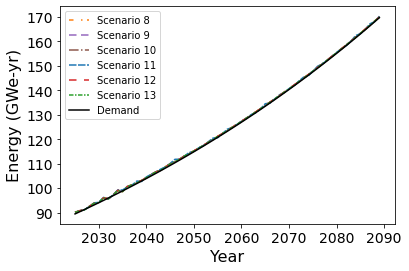

In [9]:
for key in energy_1percent:
    scenario = key[:3]
    plt.figure(0)
    plt.plot(energy_1percent[key]['Year'], energy_1percent[key]['Energy'], label=labels[scenario],
            linestyle=lines[scenario], color=colors[scenario])
    
    plt.figure(1)
    plt.plot(energy_1percent[key]['Year'][58:], energy_1percent[key]['Energy'][58:], label=labels[scenario],
            linestyle=lines[scenario], color=colors[scenario])
plt.figure(0)
plt.plot(np.linspace(2025,2089,65), 89.45655* np.exp(0.01*(time-2025)), 'k', label='Demand')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Energy (GWe-yr)', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/1percent_energy.pdf', bbox_inches='tight')

plt.figure(1)
plt.plot(np.linspace(2025,2089,65), 89.45655* np.exp(0.01*(time-2025)), 'k', label='Demand')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Energy (GWe-yr)', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/1percent_energy_after_2025.pdf', bbox_inches='tight')

In [143]:
prototype_energy_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'',
                            's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'',
                            's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'',
                            's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'',
                            's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'', 
                            's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':''}

for scenario in ['s08','s09','s10','s11','s12','s13']:
    for reactor in ['MMR', 'Xe-100','VOYGR']:
        prototype_energy_1percent[scenario + '_' + reactor] = tm.get_prototype_energy(out_files_1percent[scenario +'_outfile'], reactor)
    prototype_energy_1percent[scenario + '_LWR'] = tm.get_lwr_energy(out_files_1percent[scenario +'_outfile'], ['MMR', 'Xe-100','VOYGR'])

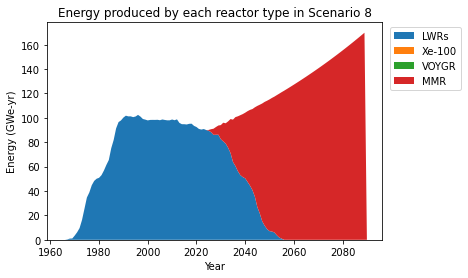

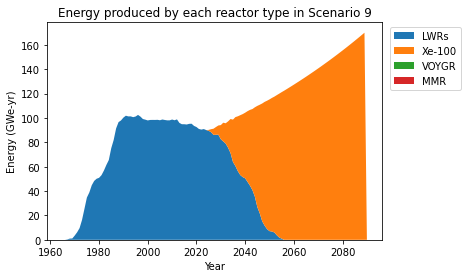

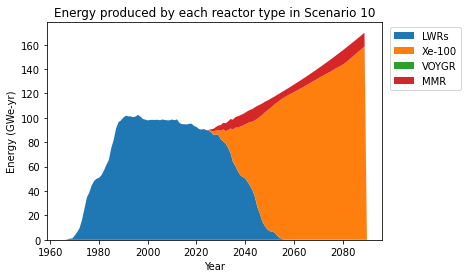

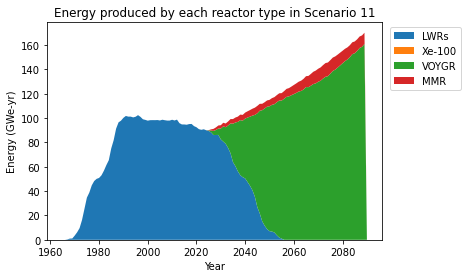

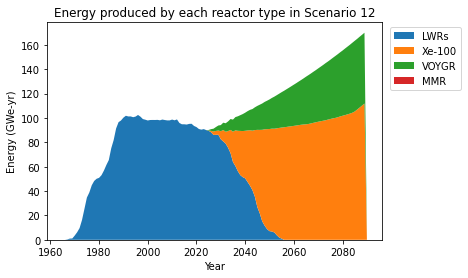

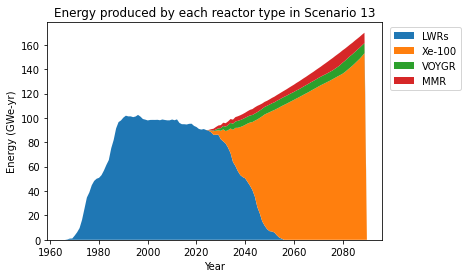

In [144]:
for scenario in ['s08','s09','s10','s11','s12','s13']:
    plt.figure()
    plt.stackplot(prototype_energy_1percent[scenario+'_LWR']['Year'], prototype_energy_1percent[scenario+'_LWR']['Energy'],
                 prototype_energy_1percent[scenario+'_Xe-100']['Energy'], prototype_energy_1percent[scenario+'_VOYGR']['Energy'],
                 prototype_energy_1percent[scenario+'_MMR']['Energy'], labels = ['LWRs','Xe-100','VOYGR','MMR'])
    plt.xlabel('Year')
    plt.ylabel('Energy (GWe-yr)')
    plt.title(f'Energy produced by each reactor type in {labels[scenario]}')
    plt.legend(bbox_to_anchor=(1.25, 1))
    plt.savefig(f'figures/prototype_energy_{scenario}.png', bbox_inches='tight')

In [5]:
# Fuel mass
transactions_1percent = {'s08':'', 's09':'', 's10':'','s11':'', 's12':'','s13':''}
total_fuel_1percent = {'s08':'', 's09':'', 's10':'',
                       's11':'', 's12':'', 's13':''}

for key in total_fuel_1percent:
    scenario = key[:3]
    transactions_1percent[scenario] = tm.add_receiver_prototype(out_files_1percent[scenario + '_outfile'])
    fuel = tm.commodity_mass_traded(transactions_1percent[scenario], 'fresh_uox')
    total_fuel_1percent[key] = tm.add_year(fuel)

In [6]:
#Dividing fuel mass by prototype
uranium_to_reactors_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'', 's08_total':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'', 's09_total':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'', 's10_total':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'', 's11_total':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'', 's12_total':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':'', 's13_total':'',}

for key in uranium_to_reactors_1percent:
    scenario = key[:3]
    reactor = key[4:]
    if reactor == 'LWR':
        uranium_to_reactors_1percent[key] = tm.commodity_to_LWR(transactions_1percent[scenario], 
                                                        'fresh_uox', adv_rxs)
    elif reactor != 'total': 
        uranium_to_reactors_1percent[key] = tm.commodity_to_prototype(transactions_1percent[scenario], 
                                                        'fresh_uox', reactor)
        uranium_to_reactors_1percent[key]['Quantity'] = uranium_to_reactors_1percent[key]['Quantity']*uranium_fractions[reactor]

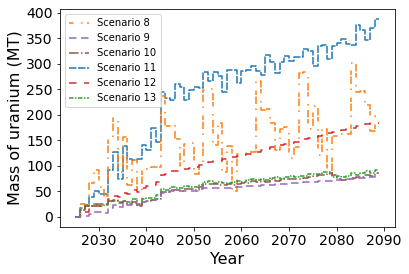

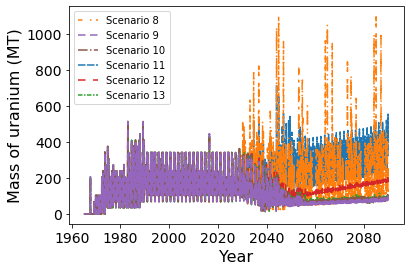

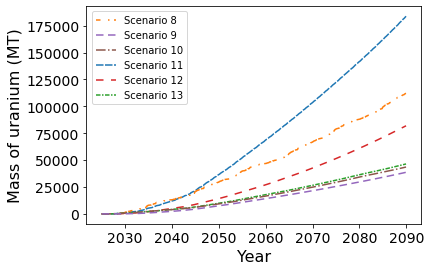

In [7]:
for key in plotting_order_1percent:

    ax1 = plt.figure(1)
    AR_uranium = uranium_to_reactors_1percent[key + '_MMR'].copy()
    for reactor in ['Xe-100', 'VOYGR']:
        AR_uranium['Quantity'] += uranium_to_reactors_1percent[key+'_'+reactor]['Quantity']
    counter = 721
    averages = []
    for ii in range(0,65):
        year_data = AR_uranium['Quantity'][counter:counter+12]/1000
        averages.append(year_data.mean())
        counter += 12
    plt.step(np.linspace(2025, 2089, 65), averages, label=labels[key],
            color=colors[key], linestyle=lines[key]) 
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('', bbox_inches='tight')

    ax2 = plt.figure(2)
    uranium_to_reactors_1percent[key+'_total'] = AR_uranium['Quantity'] + \
                                                uranium_to_reactors_1percent[key+'_LWR']['Quantity']
    plt.plot(AR_uranium['Year'], uranium_to_reactors_1percent[key+'_total']/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('', bbox_inches='tight')
    
    ax3 = plt.figure(3)
    plt.plot(AR_uranium['Year'][721:], AR_uranium['Quantity'][721:].cumsum()/1000, 
             label=labels[key], linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/1percent_AR_uranium.pdf', bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax2.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax2.savefig('figures/1percent_uranium.pdf', bbox_inches='tight')
handles, legend_labels = ax3.gca().get_legend_handles_labels()
ax3.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax3.savefig('figures/1percent_uranium_cumulative.pdf', bbox_inches='tight')

In [8]:
#Reporting uranium masses
for scenario in ['s08','s09','s10','s11','s12','s13']:
    HALEU_mass = uranium_to_reactors_1percent[scenario+'_MMR']['Quantity'] + \
                uranium_to_reactors_1percent[scenario+'_Xe-100']['Quantity']
    print('Average HALEU mass in', scenario,'after 2025:', HALEU_mass[721:].mean()/1000)
    AR_mass = HALEU_mass + uranium_to_reactors_1percent[scenario+'_VOYGR']['Quantity']
    print('Average mass in ', scenario, ':', AR_mass[721:].mean()/1000)
    print('Maximum mass in ', scenario, ':', AR_mass[721:].max()/1000) 
    print('Cumulative mass in ', scenario, ':', AR_mass[721:].cumsum()[1499]/1000)    

Average HALEU mass in s08 after 2025: 143.84384400695944
Average mass in  s08 : 143.84384400695944
Maximum mass in  s08 : 1096.0130937963183
Cumulative mass in  s08 : 112054.35448142108
Average HALEU mass in s09 after 2025: 49.6528421479255
Average mass in  s09 : 49.6528421479255
Maximum mass in  s09 : 98.35748732025071
Cumulative mass in  s09 : 38679.56403323394
Average HALEU mass in s10 after 2025: 55.94761075731802
Average mass in  s10 : 55.94761075731802
Maximum mass in  s10 : 109.93024214042454
Cumulative mass in  s10 : 43583.18877995076
Average HALEU mass in s11 after 2025: 9.3135563945463
Average mass in  s11 : 235.85388846911025
Maximum mass in  s11 : 616.1834563623288
Cumulative mass in  s11 : 183730.17911743702
Average HALEU mass in s12 after 2025: 35.48187742640938
Average mass in  s12 : 105.14475467177148
Maximum mass in  s12 : 200.2491210499108
Cumulative mass in  s12 : 81907.76388931
Average HALEU mass in s13 after 2025: 54.173044614548125
Average mass in  s13 : 59.603855

In [9]:
#SWU Calculations
tails_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':''}

feed_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'', 's08_total':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'', 's09_total':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'', 's10_total':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'', 's11_total':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'', 's12_total':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':'', 's13_total':'',}

SWU_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'', 's08_total':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'', 's09_total':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'', 's10_total':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'', 's11_total':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'', 's12_total':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':'', 's13_total':'',}
for key in feed_1percent:
    scenario = key[:3]
    reactor = key[4:]
    if reactor != 'total':
        tails_1percent[key] = tm.calculate_tails(uranium_to_reactors_1percent[key]['Quantity'], 
                                    assays[reactor], assays['tails'], assays['feed'])
        feed_1percent[key] = tm.calculate_feed(uranium_to_reactors_1percent[key]['Quantity'], 
                                           tails_1percent[key])
        SWU_1percent[key] = tm.calculate_SWU(uranium_to_reactors_1percent[key]['Quantity'],
                                assays[reactor], tails_1percent[key], assays['tails'],
                                feed_1percent[key], assays['feed'])

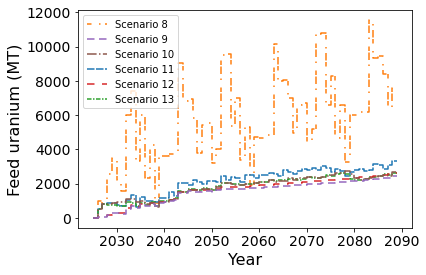

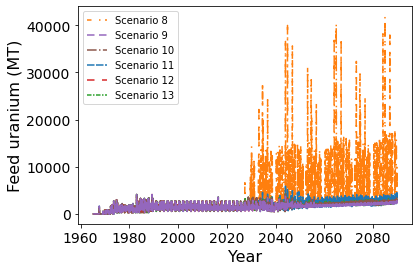

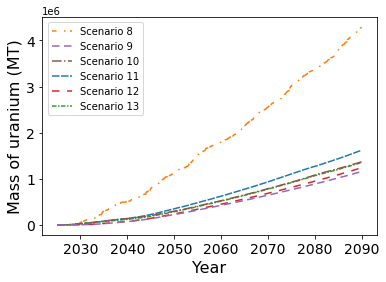

In [10]:
for key in ['s08','s11','s13','s12','s10','s09']:
    AR_feed = feed_1percent[key+'_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_feed += feed_1percent[key + '_' + reactor]
    counter = 721
    averages = []
    for ii in range(0,65):
        year_data = AR_feed[counter:counter+12]/1000
        averages.append(year_data.mean())
        counter += 12
    ax0 = plt.figure(0)
    plt.step(np.linspace(2025, 2089, 65), averages, label=labels[key],
            color=colors[key], linestyle=lines[key]) 
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax1 = plt.figure(1)
    feed_1percent[key+'_total'] = AR_feed + feed_1percent[key +'_LWR']
    plt.plot(uranium_to_reactors_1percent[key + '_MMR']['Year'], feed_1percent[key+'_total']/1000, 
             label=labels[key], linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax2 = plt.figure(2)
    plt.plot(uranium_to_reactors_1percent[key+'_MMR']['Year'][721:], AR_feed[721:].cumsum()/1000, 
             label=labels[key], linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
order = [0, 5, 4, 1, 3, 2]
handles, legend_labels = ax0.gca().get_legend_handles_labels()
ax0.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax0.savefig('figures/1percent_AR_feed.pdf', bbox_inches='tight')
handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/1percent_feed.pdf', bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax2.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax2.savefig('figures/1percent_feed_cumulative.pdf', bbox_inches='tight')

In [11]:
#Reporting feed masses
for scenario in ['s08','s09','s10','s11','s12','s13']:
    HALEU_feed = feed_1percent[scenario+'_MMR']+feed_1percent[scenario+'_Xe-100']
    print('Average HALEU feed in',scenario,'after 2025:', HALEU_feed[721:].mean()/1000)
    AR_feed = HALEU_feed + feed_1percent[scenario+'_VOYGR']
    print('Average mass in ', scenario, ':', AR_feed[721:].mean()/1000)
    print('Maximum mass in ', scenario, ':', AR_feed[721:].max()/1000)
    print('Cumulative mass in ', scenario, ':', AR_feed[721:].cumsum()[1499]/1000)

Average HALEU feed in s08 after 2025: 5503.223386176236
Average mass in  s08 : 5503.223386176236
Maximum mass in  s08 : 41931.6164064932
Cumulative mass in  s08 : 4287011.017831288
Average HALEU feed in s09 after 2025: 1486.670224781331
Average mass in  s09 : 1486.670224781331
Maximum mass in  s09 : 2944.950207436078
Cumulative mass in  s09 : 1158116.1051046557
Average HALEU feed in s10 after 2025: 1758.1499344067356
Average mass in  s10 : 1758.1499344067356
Maximum mass in  s10 : 3446.517787505719
Cumulative mass in  s10 : 1369598.7989028466
Average HALEU feed in s11 after 2025: 356.32099317686925
Average mass in  s11 : 2080.8648126877374
Maximum mass in  s11 : 5058.018693196715
Cumulative mass in  s11 : 1620993.689083748
Average HALEU feed in s12 after 2025: 1062.3732380118659
Average mass in  s12 : 1592.6835951243092
Maximum mass in  s12 : 3166.257648290895
Cumulative mass in  s12 : 1240700.5206018367
Average HALEU feed in s13 after 2025: 1696.4008659735532
Average mass in  s13 : 17

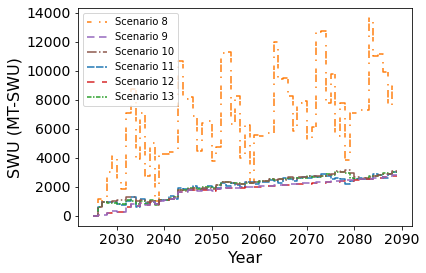

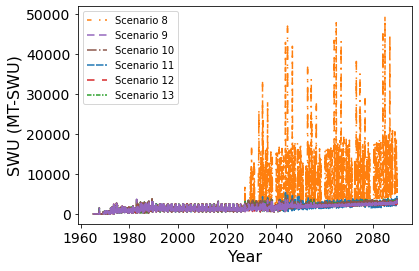

In [12]:
for key in ['s08','s11', 's13','s12','s10','s09']:
    AR_SWU = SWU_1percent[key+'_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_SWU += SWU_1percent[key + '_' + reactor]
    counter = 721
    averages = []
    for ii in range(0,65):
        year_data = AR_SWU[counter:counter+12]/1000
        averages.append(year_data.mean())
        counter += 12
    ax0 = plt.figure(0)
    plt.step(np.linspace(2025, 2089, 65), averages, label=labels[key],
            color=colors[key], linestyle=lines[key]) 
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (MT-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax1 = plt.figure(1)
    SWU_1percent[key+'_total'] = AR_SWU + SWU_1percent[key +'_LWR']
    plt.plot(uranium_to_reactors_1percent[key + '_MMR']['Year'], SWU_1percent[key+'_total']/1000, 
             label=labels[key], linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (MT-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
order = [0, 5, 4, 1, 3,2]
handles, legend_labels = ax0.gca().get_legend_handles_labels()
ax0.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax0.savefig('figures/1percent_AR_SWU.pdf', bbox_inches='tight')
handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in order],[legend_labels[idx] for idx in order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/1percent_SWU.pdf', bbox_inches='tight')

In [13]:
#Reporting SWU requirements
for scenario in ['s08','s09','s10','s11','s12','s13']:
    HALEU_SWU = SWU_1percent[scenario+'_MMR'] + SWU_1percent[scenario+'_Xe-100']
    print('Average SWU for HALEU in', scenario, 'after 2025:', HALEU_SWU[721:].mean()/1000)
    AR_SWU = HALEU_SWU + SWU_1percent[scenario+'_VOYGR']
    print('Average capacity in ', scenario, ':', AR_SWU[721:].mean()/1000)
    print('Maximum capacity in ', scenario, ':', AR_SWU[721:].max()/1000)   

Average SWU for HALEU in s08 after 2025: 6489.987444832937
Average capacity in  s08 : 6489.987444832937
Maximum capacity in  s08 : 49450.230332877276
Average SWU for HALEU in s09 after 2025: 1711.5912118799772
Average capacity in  s09 : 1711.5912118799772
Maximum capacity in  s09 : 3390.496971319314
Average SWU for HALEU in s10 after 2025: 2034.8404130420809
Average capacity in  s10 : 2034.8404130420809
Maximum capacity in  s10 : 3987.930434828942
Average SWU for HALEU in s11 after 2025: 420.2116850021375
Average capacity in  s11 : 1949.1299318062431
Maximum capacity in  s11 : 4618.493051415073
Average SWU for HALEU in s12 after 2025: 1223.1015780147472
Average capacity in  s12 : 1693.2555818071144
Maximum capacity in  s12 : 3391.372900796175
Average SWU for HALEU in s13 after 2025: 1962.6388571849989
Average capacity in  s13 : 1999.2913389109979
Maximum capacity in  s13 : 4024.0445931284094


In [14]:
# Waste discharged from reactors
waste_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'', 's08_total':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'', 's09_total':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'', 's10_total':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'', 's11_total':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'', 's12_total':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':'', 's13_total':'',}

for key in waste_1percent:
    scenario = key[:3]
    reactor = key[4:]
    if reactor != 'total':
        waste_1percent[key] = tm.commodity_mass_traded(transactions_1percent[scenario], waste_commodity[reactor])

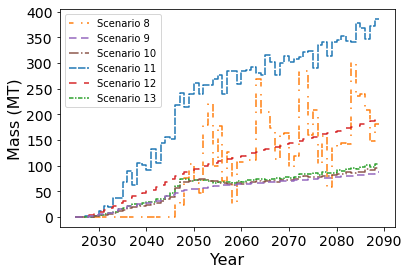

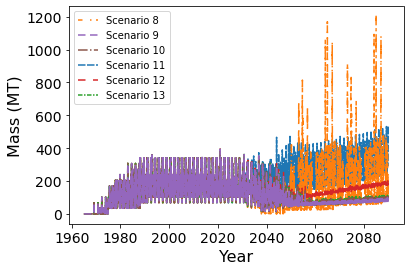

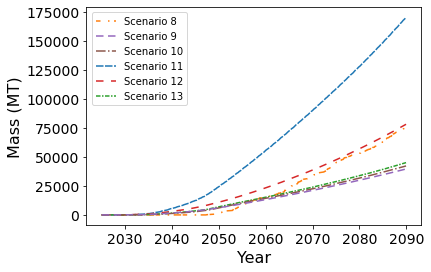

In [15]:
for key in plotting_order_1percent:
    AR_waste = waste_1percent[key + '_MMR'].copy()
    for reactor in ['Xe-100', 'VOYGR']:
        AR_waste['Quantity'] += waste_1percent[key + '_' + reactor]['Quantity']
    counter = 721
    averages = []
    for ii in range(0,65):
        year_data = AR_waste['Quantity'][counter:counter+12]/1000
        averages.append(year_data.mean())
        counter += 12
    ax0 = plt.figure(0)
    plt.step(np.linspace(2025, 2089, 65), averages, label=labels[key],
            color=colors[key], linestyle=lines[key]) 
       
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax1 = plt.figure(1)
    waste_1percent[key+'_total'] = AR_waste['Quantity'] + waste_1percent[key + '_LWR']['Quantity']
    plt.plot(AR_waste['Year'], waste_1percent[key+'_total']/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    ax2 = plt.figure(2)
    plt.plot(AR_waste['Year'][721:], AR_waste['Quantity'][721:].cumsum()/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
handles, legend_labels = ax0.gca().get_legend_handles_labels()
ax0.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax0.savefig('figures/1percent_AR_waste.pdf', bbox_inches='tight')
handles, legend_labels = ax1.gca().get_legend_handles_labels()
ax1.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax1.savefig('figures/1percent_waste.pdf', bbox_inches='tight')
handles, legend_labels = ax2.gca().get_legend_handles_labels()
ax2.legend([handles[idx] for idx in legend_order],[legend_labels[idx] for idx in legend_order], bbox_to_anchor=(0.37, 0.88))
ax2.savefig('figures/1percent_waste_cumulative.pdf', bbox_inches='tight')

In [16]:
#Reporting waste masses
for scenario in ['s08','s09','s10','s11','s12','s13']:
    HALEU_waste = waste_1percent[scenario+'_MMR']['Quantity'] + waste_1percent[scenario+'_Xe-100']['Quantity']
    print('Average HALEU waste in',scenario,'after 2025:', HALEU_waste[721:].mean()/1000)
    AR_waste = HALEU_waste + waste_1percent[scenario+'_VOYGR']['Quantity']
    print('Average mass in ', scenario, ':', AR_waste[721:].mean()/1000)
    print('Maximum mass in ', scenario, ':', AR_waste[721:].max()/1000)
    print('Cumulative mass in ', scenario, ':', AR_waste[721:].cumsum()[1499]/1000)

Average HALEU waste in s08 after 2025: 97.00060664441591
Average mass in  s08 : 97.00060664441591
Maximum mass in  s08 : 1202.5856559999984
Cumulative mass in  s08 : 75563.47257599981
Average HALEU waste in s09 after 2025: 50.82577278562252
Average mass in  s09 : 50.82577278562252
Maximum mass in  s09 : 101.24505000000059
Cumulative mass in  s09 : 39593.27699999993
Average HALEU waste in s10 after 2025: 54.19212388446715
Average mass in  s10 : 54.19212388446715
Maximum mass in  s10 : 111.32656000000047
Cumulative mass in  s10 : 42215.66450599989
Average HALEU waste in s11 after 2025: 6.981809499358152
Average mass in  s11 : 218.7312227214392
Maximum mass in  s11 : 534.806430000004
Cumulative mass in  s11 : 170391.62250000128
Average HALEU waste in s12 after 2025: 36.57476931964044
Average mass in  s12 : 100.29707281129664
Maximum mass in  s12 : 205.6694600000006
Cumulative mass in  s12 : 78131.41972000005
Average HALEU waste in s13 after 2025: 52.727251103979356
Average mass in  s13 : 

## Comparing DI to MI for Scenario 7
This sections comapres the number of advanced reactors deployed and the energy 
production when using a DeployInst (DI) and a ManagerInst (MI) to deploy 
the advanced reactors

In [19]:
files = {'DI':"../outputs/scenario7_di.sqlite",
         'MI':"../outputs/scenario7_MI.sqlite"}

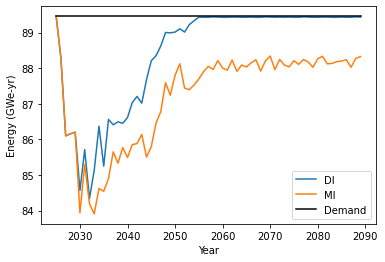

In [20]:
for file in files:
    energy = tm.get_annual_electricity(files[file])
    plt.plot(energy['Year'][58:], energy['Energy'][58:], label=file)
plt.plot(time, np.repeat(89.456, 65), 'k',label='Demand')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Energy (GWe-yr)')
plt.savefig('figures/s7_di_energy.png')
#Using the DI better meets the energy demand

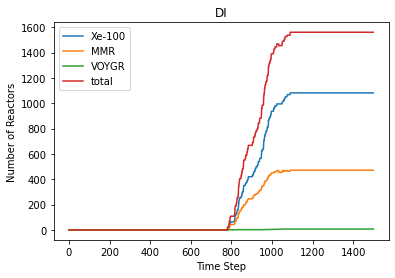

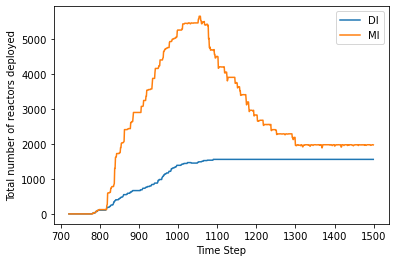

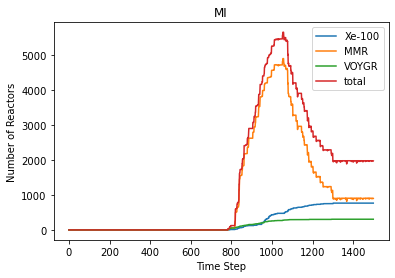

In [24]:
for file in files:
    reactors = tm.get_prototype_totals(files[file], non_lwr, adv_rxs)
    plt.figure(0)
    plt.plot(np.linspace(721, 1499, 779), reactors['advrx_total'][721:], 
             label= file)
    plt.legend()
    plt.xlabel('Time Step')
    plt.ylabel('Total number of reactors deployed')
    plt.figure()
    for reactor in ['Xe-100', 'MMR', 'VOYGR']:
        num_rxs = reactors[reactor+'_total']
        plt.plot(num_rxs, label = reactor)
    plt.plot(reactors['advrx_total'], label='total')
    plt.legend()
    plt.title(file)
    plt.xlabel('Time Step')
    plt.ylabel('Number of Reactors')
    plt.savefig(f'figures/s7_{file}.png')
# The DI deploys fewer reactors over all and fewer MMRs, which makes sense as the MMR has the 
# smallest power output of the advanced reactors

### Compare use of capacity factors

In [157]:
no_outages_file = "../outputs/mmr_voygr_CF.sqlite"
no_outages_energy = tm.get_annual_electricity(no_outages_file)

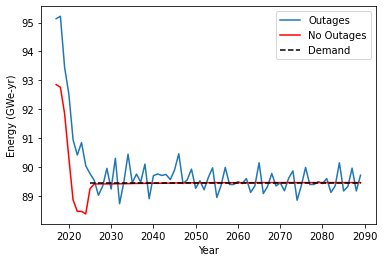

In [166]:
plt.plot(energy_nogrowth['s5_energy']['Year'][50:], energy_nogrowth['s5_energy']['Energy'][50:],label='Outages')
plt.plot(no_outages_energy['Year'][50:], no_outages_energy['Energy'][50:], 'r',label='No Outages')
plt.plot(np.linspace(2025, 2089, 65), np.repeat(89.456, 65), 'k--', label='Demand')
plt.xlabel('Year')
plt.ylabel('Energy (GWe-yr)')
plt.legend()
plt.savefig('figures/compare_CF.png')